In [350]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
plt.rcParams['figure.figsize'] = (17, 5)



### Functions for features and CM

In [432]:
def plot_confusion_matrix(y_test,y_test_preds,data='test'):
    cm_test = confusion_matrix(y_test,y_test_preds,labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    sns.heatmap(cm_test,cmap=sns.color_palette('magma'),fmt ='.1f',annot=True,ax=ax)
    plt.title(f"Confusion Matrix\n{data} Data")
    plt.ylim([8,0])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    
    
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')



In [149]:
data = pd.read_csv('../features.csv')

In [150]:
data.head()

,track_id,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,...,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rmse,genre,testtrainval
0,126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,...,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,0.074824,Instrumental,training
1,54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,...,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,0.030249,Experimental,training
2,65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,...,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,0.206977,Folk,training
3,71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,...,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,0.241167,Hip-Hop,training
4,57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,...,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,0.270437,Hip-Hop,training


In [151]:
data.shape

(7997, 33)

In [152]:
data.set_index('track_id',inplace=True)

In [153]:
data.head()

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rmse,genre,testtrainval
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,0.074824,Instrumental,training
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,0.030249,Experimental,training
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,0.206977,Folk,training
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,0.241167,Hip-Hop,training
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,0.270437,Hip-Hop,training


In [154]:
data['testtrainval'].value_counts()

training      6397
test           800
validation     800
Name: testtrainval, dtype: int64

In [155]:
y = data[['genre','testtrainval']]

In [156]:
y.drop('testtrainval',axis=1,inplace=True)

In [157]:
X = data.drop(['genre','testtrainval'],axis=1)

In [159]:
X.columns

Index(['chroma_cqt', 'chroma_cens', 'chroma_stft', 'spectral_centroid',
       'spectral_bandwidth', 'spectral_contrast', 'rolloff',
       'zero_crossing_rate', 'tonnetz', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'rmse'],
      dtype='object')

In [169]:
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,test_size=0.2,shuffle=True)

In [170]:
X_train.shape,X_test.shape

((6397, 30), (1600, 30))

In [171]:
X_test

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,rmse
track_id,,,,,,,,,,,,,,,,,,,,,
14745,0.576118,0.263298,0.337389,1430.416888,1940.671156,19.874545,2880.932579,0.053099,0.008834,-124.557419,...,7.035071,-7.052393,1.357941,-4.300022,-0.207349,-4.418410,0.514454,-6.327069,-4.633186,0.133353
122628,0.371705,0.230683,0.350967,1091.335242,1566.087572,22.176127,2123.178828,0.041798,0.064391,-108.999832,...,-3.200848,-8.638644,-3.256068,-1.881014,4.560677,0.617607,-1.547857,-6.909878,2.790957,0.253767
33459,0.565533,0.275437,0.318389,1970.420812,2441.743433,20.975527,4444.973122,0.069389,0.003318,-119.224014,...,2.581417,-4.993666,-0.737880,-8.630960,1.544850,-5.980430,-1.888727,-11.206008,-3.239398,0.127050
69002,0.518678,0.249305,0.814383,812.780186,1907.413505,16.889132,1418.049759,0.006947,0.000909,-385.092987,...,10.122687,5.395014,8.507618,5.052291,7.600240,4.044794,7.258771,3.063853,6.425762,0.054621
1681,0.322460,0.221312,0.268439,2541.531466,2610.301093,24.585889,5436.100462,0.113267,0.005000,-103.483192,...,4.833695,-3.370623,-4.478036,-1.774252,-11.619190,-12.691860,-5.009701,-13.870404,-1.136343,0.153742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96400,0.529337,0.271893,0.463414,2918.092207,2558.311472,19.979890,5629.757624,0.152110,0.017410,-24.350710,...,7.957438,-2.603634,5.221315,0.062135,-1.422109,-5.102810,1.925833,-7.245701,-0.318019,0.200940
113259,0.257847,0.189521,0.292057,664.500159,1062.885523,23.947315,1150.609709,0.027660,0.048035,-259.645844,...,-3.210697,-8.958029,-5.036731,-2.734540,-6.305810,-4.263892,-5.275793,-3.160760,-1.316738,0.134239
28274,0.317388,0.195735,0.234492,703.770273,865.425517,21.966932,855.819825,0.054982,0.095305,-308.092499,...,-3.328315,-2.830545,-6.721072,-8.723057,-4.755419,-2.628036,-4.656461,-6.305823,-6.636932,0.100980


In [366]:
labels = list(y_test['genre'].value_counts().index)

In [445]:
labels

['Hip-Hop',
 'Rock',
 'International',
 'Instrumental',
 'Experimental',
 'Electronic',
 'Pop',
 'Folk']

### Random Forest

In [173]:
rf_pipeline = Pipeline([('ss', StandardScaler()),('RF',RandomForestClassifier())])

In [174]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('RF', RandomForestClassifier())])

In [175]:
rf_pipeline.score(X_train,y_train),rf_pipeline.score(X_test,y_test)

(1.0, 0.480625)

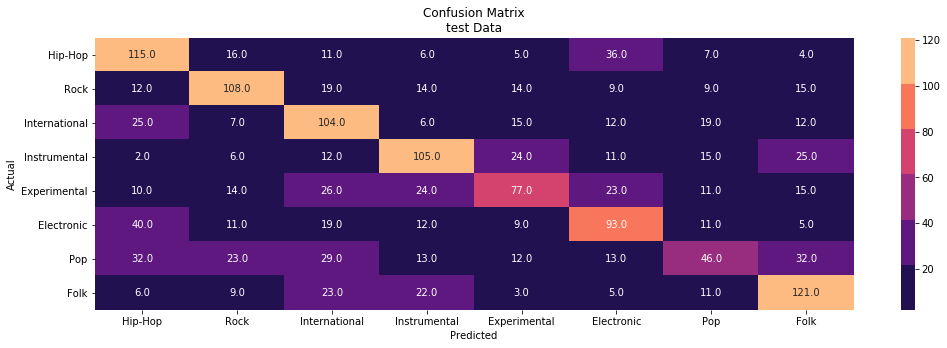

In [433]:
plot_confusion_matrix(y_test,rf_pipeline.predict(X_test))

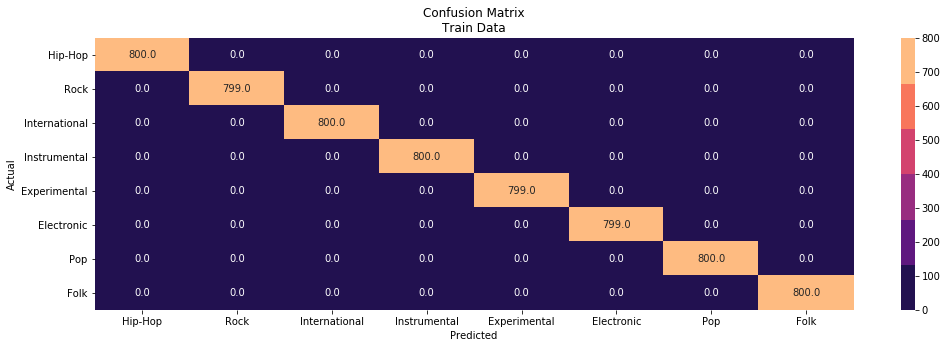

In [434]:
plot_confusion_matrix(y_train,rf_pipeline.predict(X_train),'Train')

In [205]:
params = [{'RF__max_depth': [2,4], 'RF__criterion':['gini','entropy'],
           'RF__max_features' :[2,4,6,8,'auto'],
           'RF__n_estimators':[5,10,50,100,250,500,750],
         'RF__min_samples_leaf': [1, 2, 543]}]

In [206]:
rf_cv = GridSearchCV(estimator=rf_pipeline,param_grid=params,cv=3,n_jobs=-1)

In [207]:
rf_cv.fit(X_train,y_train)

KeyboardInterrupt: 

In [199]:
rf_best = rf_cv.best_estimator_
rf_cv.best_params_

{'RF__criterion': 'gini',
 'RF__max_depth': 6,
 'RF__max_features': 6,
 'RF__min_samples_leaf': 2,
 'RF__n_estimators': 500}

In [200]:
rf_best.score(X_train,y_train),rf_best.score(X_test,y_test)

(0.5128966703142098, 0.42375)

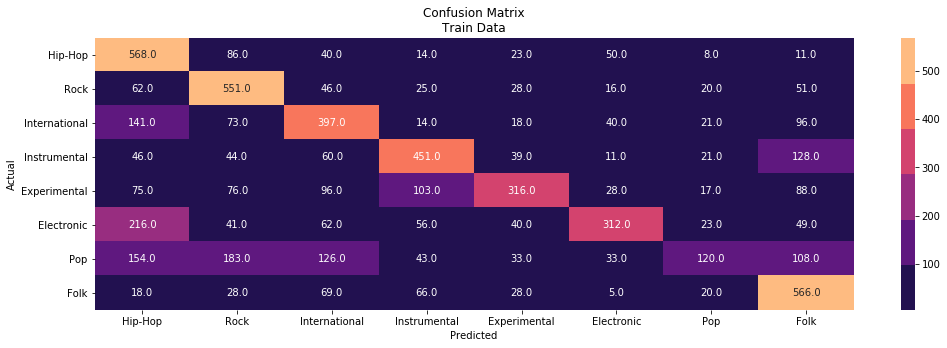

In [435]:
plot_confusion_matrix(y_train,rf_best.predict(X_train),'Train')

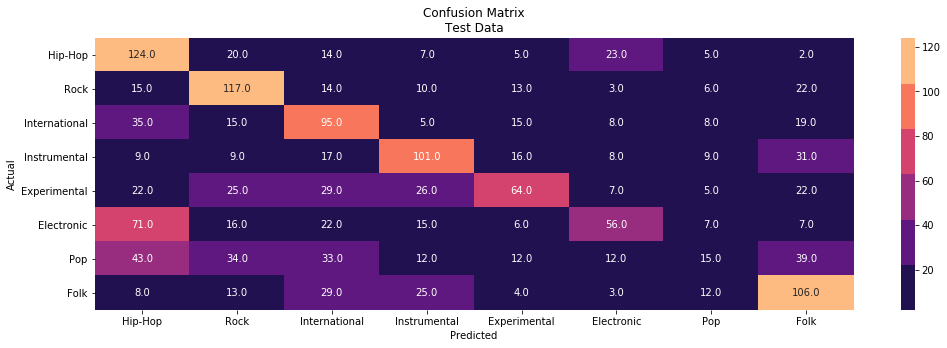

In [436]:
plot_confusion_matrix(y_test,rf_best.predict(X_test),'Test')

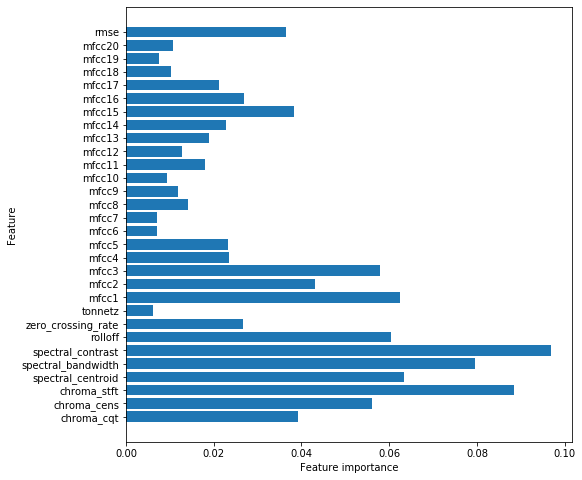

In [204]:
plot_feature_importances(rf_best[1])

### Support Vector Machines

In [232]:
svc_pipeline = Pipeline([('ss',StandardScaler()),
                    ('svc',SVC(gamma='auto',kernel='rbf'))])

In [233]:
svc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('svc', SVC(gamma='auto'))])

In [234]:
svc_pipeline.score(X_train,y_train),svc_pipeline.score(X_test,y_test)

(0.6187275285289979, 0.5)

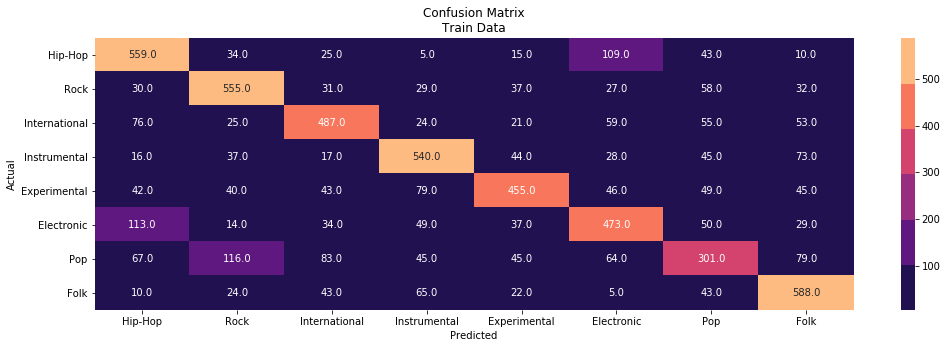

In [439]:
plot_confusion_matrix(y_train,svc_pipeline.predict(X_train),'Train')

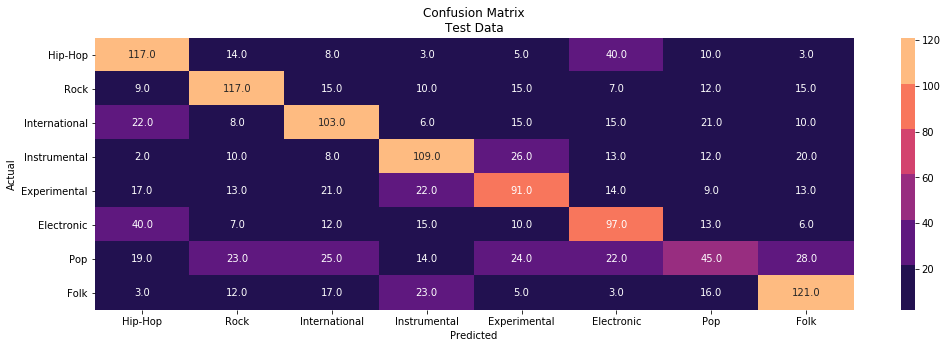

In [440]:
plot_confusion_matrix(y_test,svc_pipeline.predict(X_test),'Test')

In [237]:
params = {'svc__C':[0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,50]}

In [238]:
svc_cv = GridSearchCV(estimator =svc_pipeline,param_grid=params,n_jobs=-1,cv=2)

In [239]:
svc_cv.fit(X_train,y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('svc', SVC(gamma='auto'))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                    10, 50]})

In [240]:
svc_best = svc_cv.best_estimator_
svc_cv.best_params_

{'svc__C': 3}

In [241]:
svc_best.score(X_train,y_train),svc_best.score(X_test,y_test)

(0.7355010161012975, 0.495)

In [242]:
nusvc_pipeline = Pipeline([('ss',StandardScaler()),
                    ('nusvc',NuSVC())])

In [243]:
nusvc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('nusvc', NuSVC())])

In [244]:
nusvc_pipeline.score(X_train,y_train),nusvc_pipeline.score(X_test,y_test)

(0.6309207440987963, 0.4875)

In [245]:
linsvc_pipeline = Pipeline([('ss',StandardScaler()),
                    ('linsvc',LinearSVC())])

In [246]:
linsvc_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('linsvc', LinearSVC())])

In [247]:
linsvc_pipeline.score(X_train,y_train),linsvc_pipeline.score(X_test,y_test)

(0.4602157261216195, 0.43125)

### XGBboost

In [283]:
import xgboost as xgb


In [287]:
scaler = StandardScaler()

In [288]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
objective=

In [339]:
model = xgb.XGBClassifier(
                      scale_pos_weight=1,
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      reg_alpha = 0.1,
                      gamma=1)

In [340]:
model.fit(X_train_scaled, y_train)

XGBClassifier(colsample_bytree=0.8, gamma=1, learning_rate=0.005, max_depth=2,
              n_estimators=1000, objective='multi:softprob', reg_alpha=0.1,
              silent=False, subsample=0.8)

In [341]:
model.score(X_train_scaled, y_train),model.score(X_test_scaled, y_test)

(0.478505549476317, 0.439375)

In [342]:
xgb_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier(
                      scale_pos_weight=1,
                      colsample_bytree = 0.8,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      reg_alpha = 0.1,
                      gamma=1))])


In [343]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(colsample_bytree=0.8, gamma=1,
                               objective='multi:softprob', reg_alpha=0.1,
                               subsample=0.8))])

In [344]:
xgb_pipeline.score(X_train,y_train),xgb_pipeline.score(X_test,y_test)

(0.5994997655150852, 0.470625)

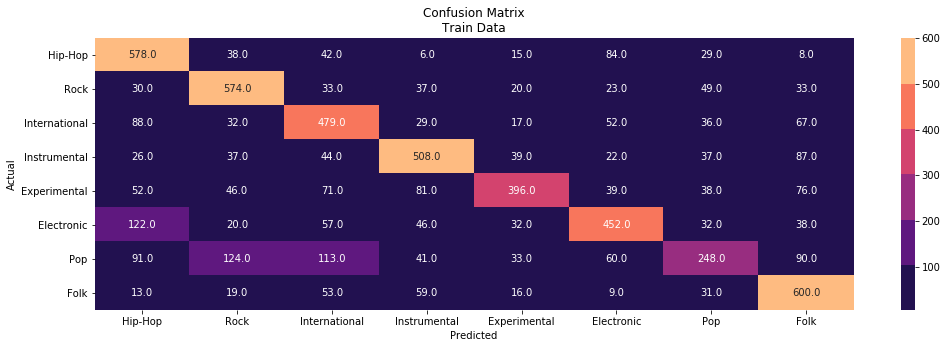

In [441]:
plot_confusion_matrix(y_train,xgb_pipeline.predict(X_train),'Train')

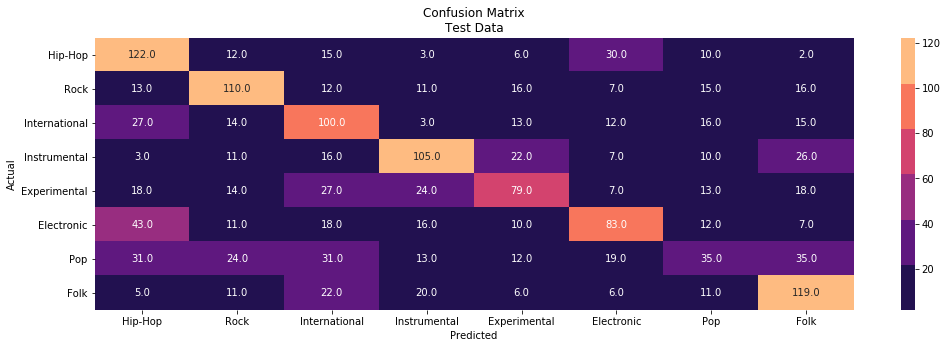

In [442]:
plot_confusion_matrix(y_test,xgb_pipeline.predict(X_test),'Test')

In [347]:
params = {
    "xgb__learning_rate": [0.001,0.005,0.05,0.01,0.1,0.5,1],
    'xgb__max_depth': [1,2,3],
    'xgb__n_estimators': [750,1000,1250,1500],
}

In [348]:
xgb_cv = GridSearchCV(estimator =xgb_pipeline,param_grid=params,n_jobs=-1,cv=5)

In [349]:
xgb_cv.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(colsample_bytree=0.8,
                                                      gamma=1,
                                                      objective='multi:softprob',
                                                      reg_alpha=0.1,
                                                      subsample=0.8))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.001, 0.005, 0.05, 0.01, 0.1,
                                                0.5, 1],
                         'xgb__max_depth': [1, 2, 3],
                         'xgb__n_estimators': [750, 1000, 1250, 1500]})

In [352]:
xgb_best = xgb_cv.best_estimator_
xgb_cv.best_params_

{'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 1250}

In [353]:
xgb_best.score(X_train,y_train),xgb_best.score(X_test,y_test)

(0.9382523057683289, 0.5025)

In [354]:
xgb_preds = xgb_best.predict(X_test)

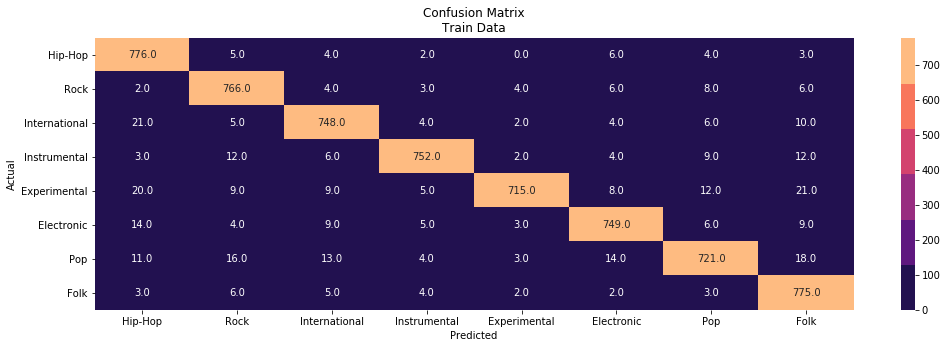

In [443]:
plot_confusion_matrix(y_train,xgb_best.predict(X_train),'Train')

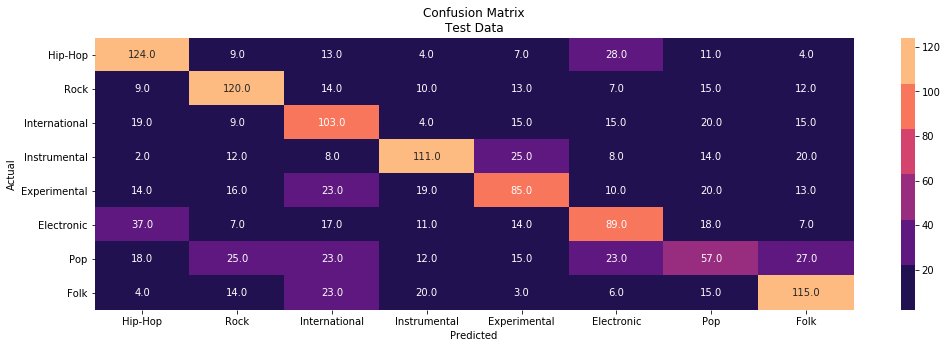

In [444]:
plot_confusion_matrix(y_test,xgb_best.predict(X_test),'Test')

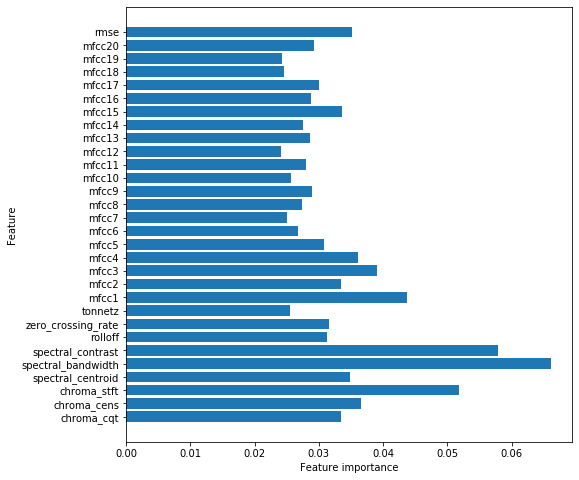

In [357]:
plot_feature_importances(xgb_best[1])